# Coverage of eADAGE LV

The goal of this notebook is to examine why genes were found to be generic. Specifically, this notebook is trying to answer the question: Are generic genes found in more multiplier latent variables compared to specific genes?

The eADAGE model uses a DAE to extracts patterns of gene expression activity in the latent variables (referred to as nodes in the paper). Here we are examining the coverage of generic genes within these latent variables.

**Definitions:**
* Generic genes: Are genes that are consistently differentially expressed across multiple simulated experiments.

* Other genes: These are all other non-generic genes. These genes include those that are not consistently differentially expressed across simulated experiments - i.e. the genes are specifically changed in an experiment. It could also indicate genes that are consistently unchanged (i.e. housekeeping genes)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import textwrap
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from ponyo import utils
from generic_expression_patterns_modules import lv

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Get data directory containing gene summary data
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
data_dir = os.path.join(base_dir, "pseudomonas_analysis")

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_pseudomonas_33245.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]

project_id = params["project_id"]

In [3]:
# Output file
nonzero_figure_filename = "nonzero_LV_coverage_eADAGE_pa.svg"
highweight_figure_filename = "highweight_LV_coverage_eADAGE_pa.svg"

## Load data

In [4]:
# Get gene summary file
summary_data_filename = os.path.join(
    data_dir, f"generic_gene_summary_{project_id}_cbrB_v_WT.tsv"
)

In [5]:
# Load gene summary data
data = pd.read_csv(summary_data_filename, sep="\t", index_col=0, header=0)

# Check that genes are unique since we will be using them as dictionary keys below
assert data.shape[0] == len(data["Gene ID"].unique())

**Manual steps to process eADAGE data**
1. Data downloaded from https://zenodo.org/record/580093
2. Get Weight matrix (`eADAGE weight matrix.xlsx`) file
3. Save tab (`weight matrix`) as .csv file in `local_dir`

In [6]:
# Load eADAGE weight matrix
eADAGE_weight_filename = os.path.join(local_dir, "eADAGE weight matrix.csv")
eADAGE_weight = pd.read_csv(eADAGE_weight_filename, sep=",", index_col=0, header=0)

In [7]:
eADAGE_weight.shape

(5549, 300)

In [8]:
# Get a rough sense for how many genes contribute to a given LV
# (i.e. how many genes have a value > 0 for a given LV)
# Notice that eADAGE is NOT sparse
(eADAGE_weight != 0).sum().sort_values(ascending=True)

Node1      5549
Node204    5549
Node203    5549
Node202    5549
Node201    5549
Node200    5549
Node199    5549
Node205    5549
Node198    5549
Node196    5549
Node195    5549
Node194    5549
Node193    5549
Node192    5549
Node191    5549
Node197    5549
Node206    5549
Node207    5549
Node208    5549
Node223    5549
Node222    5549
Node221    5549
Node220    5549
Node219    5549
Node218    5549
Node217    5549
Node216    5549
Node215    5549
Node214    5549
Node213    5549
           ... 
Node85     5549
Node84     5549
Node83     5549
Node82     5549
Node81     5549
Node80     5549
Node79     5549
Node78     5549
Node77     5549
Node92     5549
Node112    5549
Node93     5549
Node95     5549
Node110    5549
Node109    5549
Node108    5549
Node107    5549
Node106    5549
Node105    5549
Node104    5549
Node103    5549
Node102    5549
Node101    5549
Node100    5549
Node99     5549
Node98     5549
Node97     5549
Node96     5549
Node94     5549
Node300    5549
Length: 300, dtype: int6

## Get gene data

Define generic genes based on simulated gene ranking. Refer to [figure](https://github.com/greenelab/generic-expression-patterns/blob/master/pseudomonas_analysis/gene_ranking_logFC.svg) as a guide.

**Definitions:**
* Generic genes: `Percentile (simulated) >= 80`

(Having a high rank indicates that these genes are consistently changed across simulated experiments.)

* Other genes: `Percentile (simulated) < 80`

(Having a lower rank indicates that these genes are not consistently changed across simulated experiments - i.e. the genes are specifically changed in an experiment. It could also indicate genes that are consistently unchanged.)

In [9]:
generic_threshold = 80
dict_genes = lv.get_generic_specific_genes(data, generic_threshold)

(5549, 14)
No. of generic genes: 1110
No. of other genes: 4439


In [10]:
# Check overlap between eADAGE genes and our genes
eADAGE_genes = list(eADAGE_weight.index)
our_genes = list(data.index)
shared_genes = set(our_genes).intersection(eADAGE_genes)

print(len(our_genes))
print(len(shared_genes))

5549
5549


In [11]:
# Drop gene ids not used in eADAGE analysis
processed_dict_genes = lv.process_generic_specific_gene_lists(dict_genes, eADAGE_weight)

In [12]:
# Check numbers add up
assert len(shared_genes) == len(processed_dict_genes["generic"]) + len(
    processed_dict_genes["other"]
)

## Get coverage of LVs

For each gene (generic or other) we want to find:
1. The number of LVs that gene is present
2. The number of LVs that the gene contributes a lot to (i.e. the gene is highly weighted within that LV)

### Nonzero LV coverage

In [13]:
dict_nonzero_coverage = lv.get_nonzero_LV_coverage(processed_dict_genes, eADAGE_weight)

In [14]:
# Check genes mapped correctly
assert processed_dict_genes["generic"][0] in dict_nonzero_coverage["generic"].index
assert len(dict_nonzero_coverage["generic"]) == len(processed_dict_genes["generic"])
assert len(dict_nonzero_coverage["other"]) == len(processed_dict_genes["other"])

### High weight LV coverage

In [15]:
dict_highweight_coverage = lv.get_highweight_LV_coverage_pseudomonas(
    processed_dict_genes, eADAGE_weight
)

In [16]:
# Check genes mapped correctly
assert processed_dict_genes["generic"][0] in dict_highweight_coverage["generic"].index
assert len(dict_highweight_coverage["generic"]) == len(processed_dict_genes["generic"])
assert len(dict_highweight_coverage["other"]) == len(processed_dict_genes["other"])

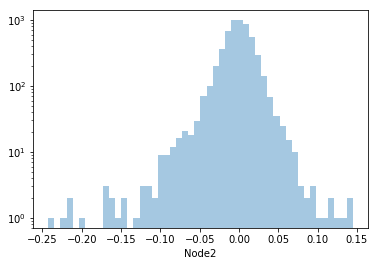

In [17]:
# Check high weight genes obtained are in fact at the extremes of the distribution
# Quick look at the distribution of gene weights per LV
sns.distplot(eADAGE_weight["Node2"], kde=False)
plt.yscale("log")

### Assemble LV coverage and plot

In [18]:
all_coverage = []
for gene_label in dict_genes.keys():
    merged_df = pd.DataFrame(
        dict_nonzero_coverage[gene_label], columns=["nonzero LV coverage"]
    ).merge(
        pd.DataFrame(
            dict_highweight_coverage[gene_label], columns=["highweight LV coverage"]
        ),
        left_index=True,
        right_index=True,
    )
    merged_df["gene type"] = gene_label
    all_coverage.append(merged_df)

all_coverage_df = pd.concat(all_coverage)

In [19]:
all_coverage_df = lv.assemble_coverage_df(
    processed_dict_genes, dict_nonzero_coverage, dict_highweight_coverage
)
all_coverage_df.head()

,nonzero LV coverage,highweight LV coverage,gene type
LocusID,,,
PA3557,300,30,generic
PA0200,300,15,generic
PA0639,300,24,generic
PA3533,300,7,generic
PA5372,300,9,generic


Text(0.5, 1.0, 'Number of LVs genes are present in')

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


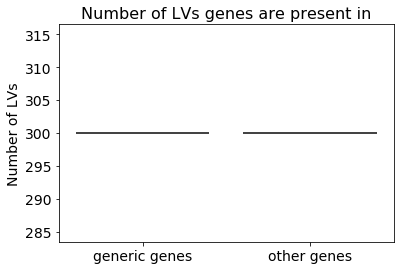

In [20]:
# Plot coverage distribution given list of generic coverage, specific coverage
nonzero_fig = sns.boxplot(
    data=all_coverage_df,
    x="gene type",
    y="nonzero LV coverage",
    notch=True,
    palette=["#2c7fb8", "lightgrey"],
)
nonzero_fig.set_xlabel(None)
nonzero_fig.set_xticklabels(
    ["generic genes", "other genes"], fontsize=14, fontname="Verdana"
)
nonzero_fig.set_ylabel(
    textwrap.fill("Number of LVs", width=30), fontsize=14, fontname="Verdana"
)
nonzero_fig.tick_params(labelsize=14)
nonzero_fig.set_title(
    "Number of LVs genes are present in", fontsize=16, fontname="Verdana"
)

Notice that since our weight matrix is not sparse, all genes are present in all 300 nodes, as expected

Text(0.5, 1.0, 'Number of LVs genes contribute highly to')

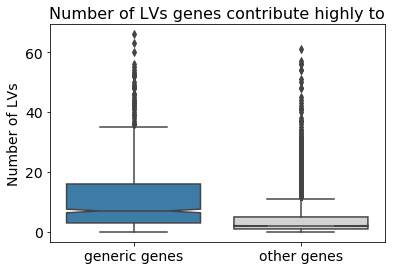

In [21]:
# Plot coverage distribution given list of generic coverage, specific coverage
highweight_fig = sns.boxplot(
    data=all_coverage_df,
    x="gene type",
    y="highweight LV coverage",
    notch=True,
    palette=["#2c7fb8", "lightgrey"],
)
highweight_fig.set_xlabel(None)
highweight_fig.set_xticklabels(
    ["generic genes", "other genes"], fontsize=14, fontname="Verdana"
)
highweight_fig.set_ylabel(
    textwrap.fill("Number of LVs", width=30), fontsize=14, fontname="Verdana"
)
highweight_fig.tick_params(labelsize=14)
highweight_fig.set_title(
    "Number of LVs genes contribute highly to", fontsize=16, fontname="Verdana"
)

## Calculate statistics
* Is the reduction in generic coverage significant?
* Is the difference between generic versus other genes signficant?

In [22]:
# Test: mean number of LVs generic genes present in vs mean number of LVs that generic gene is high weight in
# (compare two blue boxes between plots)
generic_nonzero = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "nonzero LV coverage"
].values
generic_highweight = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "highweight LV coverage"
].values

(stats, pvalue) = scipy.stats.ttest_ind(generic_nonzero, generic_highweight)
print(pvalue)

0.0


In [23]:
# Test: mean number of LVs generic genes are high weight in vs mean number of LVs other genes high weight in
# (compare blue and grey boxes in high weight plot)
other_highweight = all_coverage_df[all_coverage_df["gene type"] == "other"][
    "highweight LV coverage"
].values
generic_highweight = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "highweight LV coverage"
].values

(stats, pvalue) = scipy.stats.ttest_ind(other_highweight, generic_highweight)
print(pvalue)

4.899930672044307e-150


In [24]:
# Check that coverage of other and generic genes across all LVs is NOT signficantly different
# (compare blue and grey boxes in nonzero weight plot)
other_nonzero = all_coverage_df[all_coverage_df["gene type"] == "other"][
    "nonzero LV coverage"
].values
generic_nonzero = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "nonzero LV coverage"
].values

(stats, pvalue) = scipy.stats.ttest_ind(other_nonzero, generic_nonzero)
print(pvalue)

nan


## Get LVs that generic genes are highly weighted in

Since we are using quantiles to get high weight genes per LV, each LV has the same number of high weight genes. For each set of high weight genes, we will get the proportion of generic vs other genes. We will select the LVs that have a high proportion of generic genes to examine.

In [25]:
# Get proportion of generic genes per LV
prop_highweight_generic_dict = lv.get_prop_highweight_generic_genes_pseudomonas(
    processed_dict_genes, eADAGE_weight
)

In [26]:
proportion_generic = 0.5
generic_LV = []
for k, v in prop_highweight_generic_dict.items():
    if v > proportion_generic:
        print(k, v)
        generic_LV.append(k)

Node16 0.5862068965517241
Node25 0.6153846153846154
Node27 0.744
Node31 0.7087378640776699
Node33 0.5871559633027523
Node38 0.575
Node42 0.6129032258064516
Node45 0.6590909090909091
Node46 0.6449704142011834
Node49 0.6842105263157895
Node56 0.627906976744186
Node58 0.7426470588235294
Node68 0.5276073619631901
Node77 0.5416666666666666
Node90 0.52
Node97 0.746268656716418
Node107 0.5135135135135135
Node113 0.60431654676259
Node116 0.549618320610687
Node122 0.5401459854014599
Node130 0.55
Node136 0.5116279069767442
Node137 0.6
Node140 0.5061728395061729
Node151 0.7403846153846154
Node156 0.5212765957446809
Node158 0.5555555555555556
Node161 0.6551724137931034
Node167 0.52
Node169 0.5294117647058824
Node173 0.5145631067961165
Node174 0.6551724137931034
Node176 0.6071428571428571
Node191 0.6124031007751938
Node198 0.6349206349206349
Node199 0.5683453237410072
Node208 0.616
Node212 0.568
Node214 0.5932203389830508
Node217 0.5041322314049587
Node220 0.5742574257425742
Node224 0.5241935483870

    geneID    Node16
0   PA0997  0.184274
1   PA0998  0.174685
2   PA0999  0.172933
3   PA1000  0.170292
4   PA0996  0.169752
5   PA1001  0.169742
6   PA2514 -0.156044
7   PA2513 -0.154575
8   PA2512 -0.129668
9   PA0621  0.119120
10  PA3904  0.118266
11  PA1002  0.112581
12  PA1431  0.112065
13  PA3476  0.105985
14  PA5530 -0.093588
15  PA3907  0.092569
16  PA3906  0.092001
17  PA4107 -0.089826
18  PA2508 -0.085978
19  PA4103 -0.085839


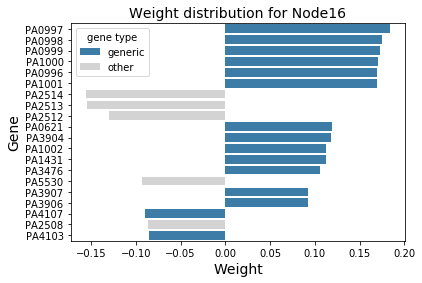

In [27]:
# Plot distribution of weights for these nodes
node = generic_LV[0]
lv.plot_dist_weights_pseudomonas(
    node, eADAGE_weight, shared_genes, 20, all_coverage_df, f"weight_dist_{node}.svg"
)

    geneID    Node25
0   PA4306 -0.131902
1   PA5506  0.112216
2   PA0587 -0.110367
3   PA3049 -0.106253
4   PA2365 -0.103959
5   PA2366 -0.099922
6   PA2746 -0.099720
7   PA0586 -0.099020
8   PA1177 -0.096395
9   PA1041 -0.095279
10  PA1728 -0.094191
11  PA2939 -0.093222
12  PA4607 -0.093089
13  PA0985 -0.091322
14  PA2372 -0.090910
15  PA5508  0.090375
16  PA4573 -0.085243
17  PA0588 -0.082000
18  PA4296 -0.081989
19  PA1746 -0.079681


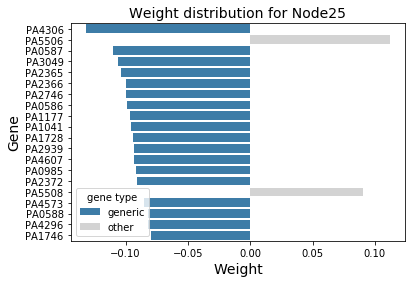

In [28]:
node = generic_LV[1]
lv.plot_dist_weights_pseudomonas(
    node, eADAGE_weight, shared_genes, 20, all_coverage_df, f"weight_dist_{node}.svg"
)

## Save

In [29]:
# Save plot
nonzero_fig.figure.savefig(
    nonzero_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

# Save plot
highweight_fig.figure.savefig(
    highweight_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**
* In the first nonzero box plot, generic and other genes are present in all LVs since the eADAGE model is fully connected.
* In the second highweight box plot, generic genes are found to contribute a lot to more LVs compared to other genes. This would indicate that generic genes are contributing alot across many LVs compared to other genes, that contribute a lot more specifically to some LVs.